# Decision Analysis

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def read_data(filename):
    df = pd.read_csv(filename, index_col=0, skiprows=1).dropna().transpose()
    return df

In [3]:
df2011 = read_data('./data/showcases.2011.csv')
df2012 = read_data('./data/showcases.2012.csv')

In [4]:
df = pd.concat([df2011, df2012], ignore_index=True)

In [5]:
df.head()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
3,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
4,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


In [6]:
df.columns = ['showcase_1', 'showcase_2', 'bid_1', 'bid_2', 'diff1', 'diff2']

In [7]:
df.head()

,showcase_1,showcase_2,bid_1,bid_2,diff1,diff2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
3,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
4,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


### Kernel Density Estimation

Estimate prior distribution of showcase price.<br/>
The KDE will estimate the smooth distribution of the prior distribution.

In [8]:
# qs is the hypothetical values
def make_kde(sample, qs):
    # create kde with sample
    kde = stats.gaussian_kde(sample)
    # evaluate the kde with a sequence of quantities
    pdf = kde.pdf(qs)
    pdf = pdf/pdf.sum()
    df = pd.DataFrame(index=qs, data=pdf, columns=['probs'])
    return df

In [9]:
df[['showcase_1', 'showcase_2']].describe()

,showcase_1,showcase_2
count,313.000000,313.000000
mean,30299.488818,31047.680511
std,7145.705405,8293.059002
min,19563.000000,18349.000000
25%,24866.000000,25264.000000
50%,28958.000000,29488.000000
75%,34428.000000,34665.000000
max,58342.000000,71628.000000


In [10]:
qs = np.linspace(0,80000, 81)
prior1 = make_kde(df['showcase_1'], qs)

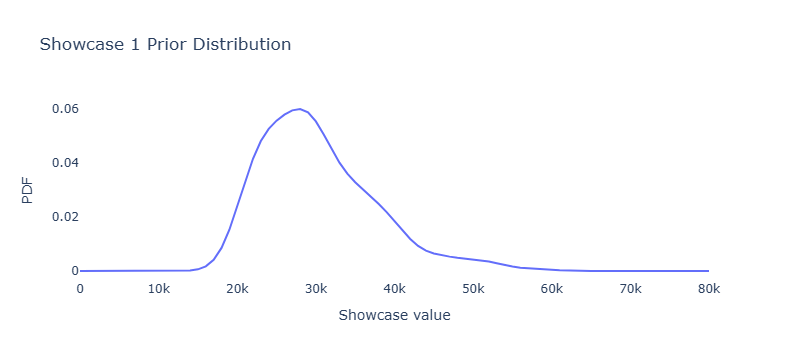

In [74]:
fig = go.Figure()

fig.add_trace(
    go.Line(
        x=prior1.index,
        y=prior1['probs']
    )
)

fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_title='Showcase value',
    yaxis_title='PDF',
    title='Showcase 1 Prior Distribution'
)

fig.show()

In [12]:
np.sum(prior1.index*prior1.probs), np.mean(df['showcase_1'])

(np.float64(30299.488817891375), np.float64(30299.488817891375))

In [13]:
prior2 = make_kde(df['showcase_2'], qs)

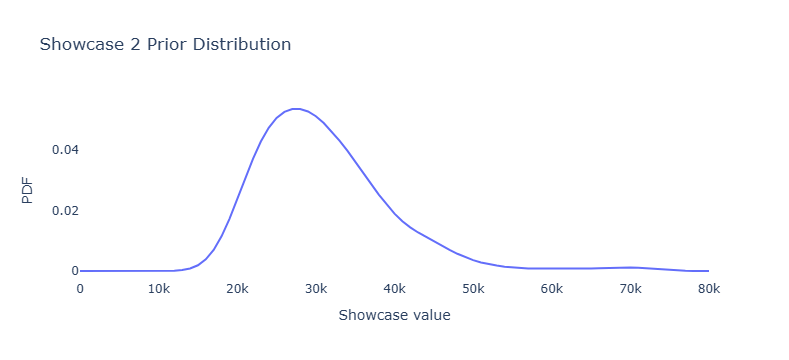

In [73]:
fig = go.Figure()

fig.add_trace(
    go.Line(
        x=prior2.index,
        y=prior2['probs']
    )
)

fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_title='Showcase value',
    yaxis_title='PDF',
    title='Showcase 2 Prior Distribution'
)

fig.show()

In [15]:
np.sum(prior2.index*prior2['probs']), np.mean(df['showcase_2'])

(np.float64(31047.62371912251), np.float64(31047.68051118211))

### Distribution Error

What is the likelihood that the constestan's guess is off by error?<br/>

To answer this question, we will use the historical data again. For each showcase in the dataset, let's look at the difference between the contestant's bid and the actual price.

In [16]:
sample_diff1 = df['bid_1'] - df['showcase_1']
sample_diff2 = df['bid_2'] - df['showcase_2']

To visualize the distribution of these differences, we can use KDE again

In [17]:
stats.norm.fit(sample_diff1) # mean and std

(np.float64(-4116.3961661341855), np.float64(6888.878768457381))

In [18]:
stats.norm.fit(sample_diff2) # mean and std

(np.float64(-3675.891373801917), np.float64(6875.251494512836))

In [19]:
sample_diff1.describe(), sample_diff2.describe()

(count      313.000000
 mean     -4116.396166
 std       6899.909806
 min     -31374.000000
 25%      -7800.000000
 50%      -3902.000000
 75%        -26.000000
 max      14187.000000
 dtype: float64,
 count      313.000000
 mean     -3675.891374
 std       6886.260711
 min     -43628.000000
 25%      -7829.000000
 50%      -3136.000000
 75%        587.000000
 max      25839.000000
 dtype: float64)

In [20]:
# hypothetical values of the diff
qs = np.linspace(-45000, 28000, 100)
kde_diff1 = make_kde(sample_diff1, qs)
kde_diff2 = make_kde(sample_diff2, qs)

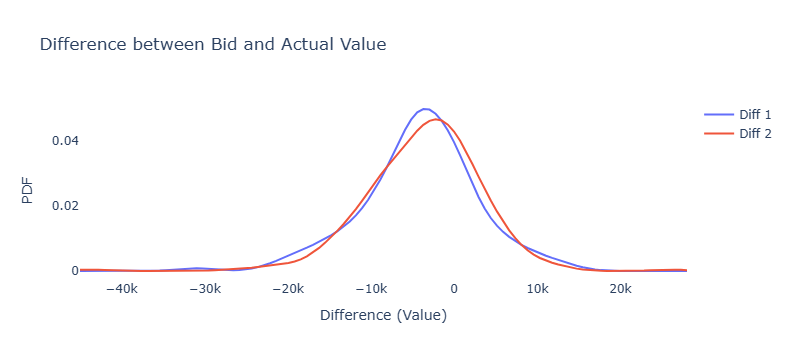

In [72]:
fig = go.Figure()

fig.add_trace(
    go.Line(
        x=kde_diff1.index,
        y=kde_diff1['probs'],
        name='Diff 1'
    )
)

fig.add_trace(
    go.Line(
        x=kde_diff2.index,
        y=kde_diff2['probs'],
        name='Diff 2'
    )
)


fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_title='Difference (Value)',
    yaxis_title='PDF',
    title='Difference between Bid and Actual Value'
)

fig.show()

It loos lie the bids are too low more often than too high, which makes sense.<br/>
The contestants probably under bid to some degree deliberately.<br/>
The distribuitions contains negative and positive values, and it looks like they are well modeled by a normal distribution.

In [22]:
mean_diff1 = np.mean(sample_diff1)
std_diff1 = np.std(sample_diff1)

mean_diff2 = np.mean(sample_diff2)
std_diff2 = np.std(sample_diff2)

mean_diff1, mean_diff2, std_diff1, std_diff2

(np.float64(-4116.3961661341855),
 np.float64(-3675.891373801917),
 np.float64(6888.878768457381),
 np.float64(6875.251494512836))

In [23]:
error_dist1 = stats.norm(loc=0, scale=std_diff1) # loc is mean and scale is std
error_dist2 = stats.norm(loc=0, scale=std_diff2) 

In [24]:
error = -100

# the pdf of having error -100 based on distribution of errors for showcase 1
print(error_dist1.pdf(error))

# the pdf of having error -100 based on distribution of errors for showcase 2
print(error_dist2.pdf(error))

5.790496011607006e-05
5.801970791619915e-05


By itself, the number doesn't mean very much, because probability densities are not probabilities. But they are proportional to probabilities, so we can use them as likelihoods in a Bayesian update.

### Update

Suppose you are Player 1. You see the prizes in your showcase and your guess for the total price is $23,000.<br/>

From your guess, we will subtract away each hypothetical price in the prior distribution; the result is our error under each hypothesis

In [25]:
guess1 = 23000
error1 = guess1 - prior1.index

Based on past performance, that our estimation error is well modeled by error_dist. Under that assumption we can compute the likelihood of our error under each hypothesis.

In [26]:
qs = np.linspace(0,80000, 81)

In [27]:
likelihood1 = error_dist1.pdf(error1)
posterior1 = prior1['probs'] * likelihood1
posterior1 = posterior1/posterior1.sum()
df_posterior1 = pd.DataFrame(index=qs, data=posterior1, columns=['probs'])

In [28]:
df_posterior1

,probs
0.0,4.593710e-22
1000.0,3.118260e-20
2000.0,1.712602e-18
3000.0,7.616427e-17
4000.0,2.745429e-15
...,...
76000.0,8.392800e-30
77000.0,7.874517e-32
78000.0,5.952291e-34
79000.0,3.624828e-36


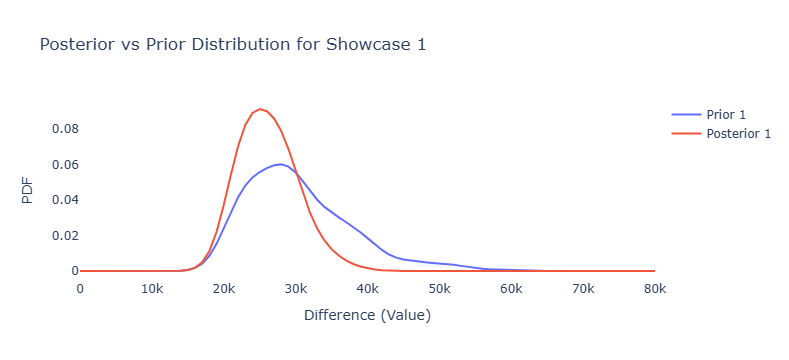

In [71]:
fig = go.Figure()

fig.add_trace(
    go.Line(
        x=prior1.index,
        y=prior1['probs'],
        name='Prior 1'
    )
)

fig.add_trace(
    go.Line(
        x=df_posterior1.index,
        y=df_posterior1['probs'],
        name='Posterior 1'
    )
)


fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_title='Difference (Value)',
    yaxis_title='PDF',
    title='Posterior vs Prior Distribution for Showcase 1'
)

fig.show()

In [30]:
np.sum(df_posterior1.index*df_posterior1.probs), df['showcase_1'].mean()

(np.float64(26186.963378201523), np.float64(30299.488817891375))

Because your initial guess is in the lower end of the range, the posterior distribution has shifted to the left. We can refer to the posterior mean above to see by how much.<br/>

Before we saw the prizes, we expected to see a showcase with a value close to 30,000. After making a guess of 23,000 we updated the prior distribution. Based on the combination of the prior and our guess, we now expect the actual price to be about 26,000

In [31]:
qs = np.linspace(0, 80000, 81)
guess = 38000
error2 = guess - prior2.index # subtract guess with each hypothetical value
likelihood2 = error_dist2.pdf(error2) # compute the likelihood of the error under each hypothesis
posterior2 = prior2['probs']*likelihood2
posterior2 = posterior2/posterior2.sum()
df_posterior2 = pd.DataFrame(index=qs, data=posterior2, columns=['probs'])

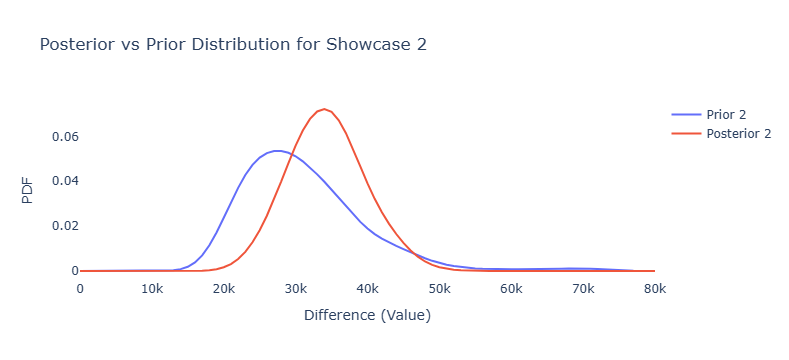

In [70]:
fig = go.Figure()

fig.add_trace(
    go.Line(
        x=prior2.index,
        y=prior2['probs'],
        name='Prior 2'
    )
)

fig.add_trace(
    go.Line(
        x=df_posterior2.index,
        y=df_posterior2['probs'],
        name='Posterior 2'
    )
)


fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_title='Difference (Value)',
    yaxis_title='PDF',
    title='Posterior vs Prior Distribution for Showcase 2'
)

fig.show()

In [33]:
np.sum(df_posterior2.index*df_posterior2['probs']), np.mean(df['showcase_1'])

(np.float64(34311.86825135375), np.float64(30299.488817891375))

Because our initial guess is on the higher end of the range, the posterior distribution has shifted to the right. We can check the posterior mean to see by how much. <br/>

Before we saw the prizes, we expected to see a showcase with a value close to 30,000. After making a guess of 38,000, we updated the prior distribution. Based on the combination of the prior and our guess, we now expect the actual price to be about 34k.

### Probability of Winning

In [34]:
# From the point of view of one player against another.
# use only the performance of past player for simplicity, ignoring the value of the showcase.
def prob_overbid(sample_diff):
    return np.mean(sample_diff > 0)

# Now suppose one player underbids by certain values. 
# What is the probability that another player underbids by more?
def prob_worse_than(diff, sample_diff):
    return np.mean(sample_diff < diff)

In [35]:
# the estimate for probability that player 2 will overbids
prob_overbid(sample_diff2)

np.float64(0.29073482428115016)

In [36]:
# the estimate for player 2 underbids by more than 5,000
prob_worse_than(-5000, sample_diff2)

np.float64(0.38338658146964855)

In [37]:
def compute_prob_win(diff, sample_diff):
    # if you overbid you lose
    if diff>0:
        return 0

    # if the opponent overbids, you win
    p1 = prob_overbid(sample_diff)

    # or if their bid is worse than yours, you win
    p2 = prob_worse_than(diff, sample_diff)

    # p1 and p2 are mutually exclusive, so we can add them
    return p1+p2

Here is the probability that we win, given that we underbid by 5,000. <br/>
The smaller the underbid (closer to the actual value), the higher the probability we win.

In [38]:
compute_prob_win(-5000, sample_diff2)

np.float64(0.6741214057507987)

In [39]:
xs = np.linspace(-30000, 5000, 121) # hypothetical values of bid (simulate underbids and overbids) or range of possible differences between bid and the actual price
ys = [compute_prob_win(x, sample_diff2) for x in xs]

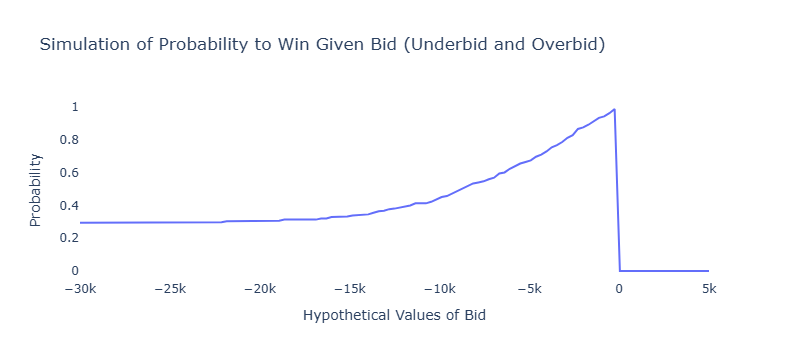

In [69]:
fig = go.Figure()

fig.add_trace(
    go.Line(
        x=xs,
        y=ys
    )
)


fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_title='Hypothetical Values of Bid',
    yaxis_title='Probability',
    title='Simulation of Probability to Win Given Bid (Underbid and Overbid)'
)

fig.show()

If you underbid by 30,000, the chance of winning is about 30%, which is mostly the chance your opponent overbids.<br/>
As your bids gets closer to the actual price, your chance of winning approaches 1.<br/>
And, of course, if you overbid, you lose (even if your opponent also overbids).

### Decision Analysis

In reality the contestants don't know how much they have underbid by, because they don't know the actual price. But they do have posterior distribution that represents their beliefs about the actual price, and they can use that to estimate their probability of winning with a given bid.

In [41]:
def total_prob_win(bid, posterior, sample_diff):
    # compute the total probability of winning with a given bid
    # bid: your bid
    # posterior: pdf of showcase value
    # sample_diff: sequence of differences for the opponent
    # return probability of winning
    total = 0
    for price, prob in posterior.items():
        diff = bid - price

        # bayesian marginalization or total probability of winning
        total += prob * compute_prob_win(diff, sample_diff) # weighting the probability of winning at each possible true price by the probability that price is correct
    return total

The above function implement the law of total probability: <br/>
P(win) = sum of P(price) P(win|price)

In [42]:
bid = 26000

total_prob_win(bid, df_posterior1['probs'], sample_diff2)

np.float64(0.42460236122382744)

Now we can loop through a series of possible bids and compute the probability of winning for each one

In [43]:
bids = df_posterior1.index

In [44]:
probs = [total_prob_win(bid, df_posterior1['probs'], sample_diff2) for bid in bids]

In [45]:
fig = go.Figure()

fig.add_trace(
    go.Line(
        x=bids,
        y=probs
    )
)

fig.update_layout(
    xaxis_title='Bid $',
    yaxis_title='Probability of Winning',
    plot_bgcolor='rgba(0,0,0,0)',
    title='Optimal Bid: Probability of Winning'
)

fig.show()

In [46]:
df_da_result = pd.DataFrame(index=bids, data=probs, columns=['probs'])

In [47]:
df_da_result.idxmax()

probs    21000.0
dtype: float64

In [48]:
df_da_result.probs.max()

np.float64(0.6138594913274742)

In [49]:
bid = 21000

total_prob_win(bid, df_posterior1['probs'], sample_diff2)

np.float64(0.6138594913274742)

### Maximizing Expected Gain

In [51]:
def compute_gain(bid, price, sample_diff):
    # compute expected gain given a bid and actual price
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)

    # if we are within 250 dollars, we win both showcases
    if -250 <= diff <= 0:
        return 2 * price * prob
    else:
        return price * prob

In [52]:
compute_gain(30000, 35000, sample_diff2)

np.float64(23594.249201277955)

If the actual price is 35,000 and we bid 30,000, we will win about 23,600 worth of prizes on average, taking into account our probability of losing, winning one showcase, or winning both.<br/>

Since we don't know the actual price in reality, we can use a posterior distribution that represents what we know about it.

In [53]:
# The average over the possible showcase values, weighted by their probabilities
def expected_gain(bid, posterior, sample_diff):
    total = 0
    for price, prob in posterior.items():
        total += prob * compute_gain(bid, price, sample_diff)
    return total

In [54]:
expected_gain(21000, posterior1, sample_diff2)

np.float64(16926.931058462324)

Find out the maximum expected gain through bids

In [58]:
bids = df_posterior1.index
gains = [expected_gain(bid, df_posterior1['probs'], sample_diff2) for bid in bids]

expected_gain_series = pd.Series(gains, index=bids)

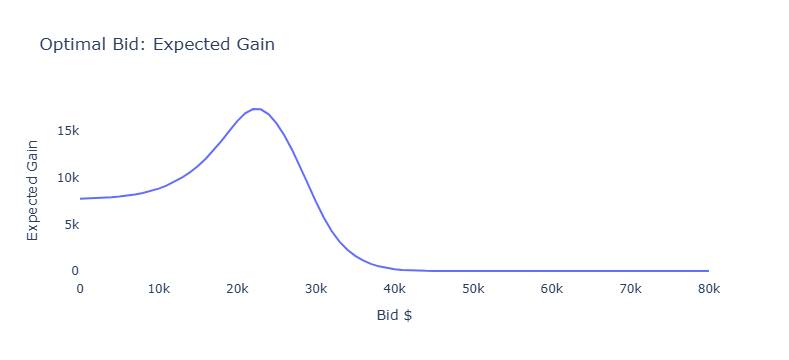

In [63]:
fig = go.Figure()

fig.add_trace(
    go.Line(
        x=expected_gain_series.index,
        y=expected_gain_series
    )
)

fig.update_layout(
    xaxis_title='Bid $',
    yaxis_title='Expected Gain',
    plot_bgcolor='rgba(0,0,0,0)',
    title='Optimal Bid: Expected Gain'
)

fig.show()

In [65]:
expected_gain_series.idxmax(), expected_gain_series.max()

(np.float64(22000.0), np.float64(17388.052911268056))

Recall that our initial guess was 23,000. The bid that maximizes the chance of winning is 21,000. And the bid that maximizes our expected gain is 22,000